In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

# Animal Welfare Center dataset

In [3]:
dataset = pd.read_csv("kaggle_files/animal_welfare_center.csv")

In [4]:
dataset.head()

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,outcome_type
0,A006100,2007,7,10 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194,10 years,2007-07-09 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,0,1.0,Return to Owner
1,A006100,2007,7,7 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2555,7.0,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722,7 years,2007-07-09 00:00:00,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,12,2014,2014-12,Saturday,16,2.0,Return to Owner
2,A006100,2007,7,6 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2190,6.0,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889,6 years,2007-07-09 00:00:00,Neutered Male,2190,6.0,"(5.0, 7.5]",NaN,3,2014,2014-03,Saturday,17,3.0,Return to Owner
3,A047759,2004,4,10 years,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,10 years,2004-04-02 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,2014,2014-04,Monday,15,1.0,Missing
4,A134067,1997,10,16 years,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,1,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444,16 years,1997-10-16 00:00:00,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,2013,2013-11,Saturday,11,1.0,Return to Owner


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47803 entries, 0 to 47802
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   animal_id_outcome           47803 non-null  object 
 1   dob_year                    47803 non-null  int64  
 2   dob_month                   47803 non-null  int64  
 3   age_upon_intake             47803 non-null  object 
 4   animal_type                 47803 non-null  object 
 5   breed                       47803 non-null  object 
 6   color                       47803 non-null  object 
 7   intake_condition            47803 non-null  object 
 8   intake_type                 47803 non-null  object 
 9   sex_upon_intake             47802 non-null  object 
 10  count                       47803 non-null  int64  
 11  age_upon_intake_(days)      47803 non-null  int64  
 12  age_upon_intake_(years)     47803 non-null  float64
 13  age_upon_intake_age_group   478

In [6]:
# List of columns that have unnecessary/redundant information
drop_columns = ["age_upon_intake", "count", "age_upon_intake_(days)", "intake_datetime", "time_in_shelter",
                "intake_monthyear" , "age_upon_outcome", "date_of_birth", "age_upon_outcome_(days)",
                "sex_upon_outcome", "age_upon_intake_age_group", "age_upon_outcome_age_group",
                "outcome_datetime", "outcome_monthyear", "outcome_number", "intake_hour", "outcome_hour"]

In [7]:
len(dataset.animal_id_outcome.unique())/len(dataset)

0.8928100746815053

The dataset has multiple entries for the same animal. About 89% of our dataset are unique animals. Enough data will remain after removing the duplicate intakes. The duplicates will be dropped.

In [8]:
# Remove duplicate rows for same animal
dataset = dataset[dataset['intake_number']== 1]

In [9]:
# now unuseful columns
drop_columns.extend(["animal_id_outcome", "intake_number"]) # use extend([]) instead of multiple append()

In [10]:
# select numerical features for correlations
numerical = dataset.select_dtypes(np.number)

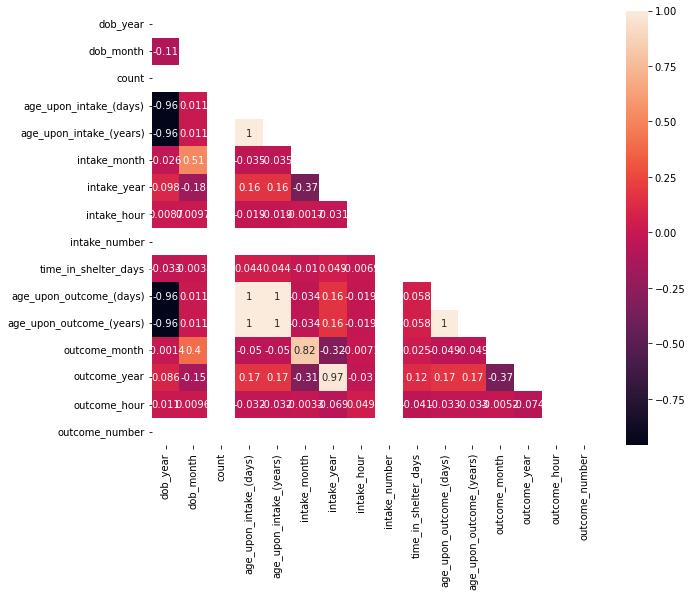

In [11]:
correlations = numerical.corr() # create the correlations

mask = np.zeros_like(correlations) # create an array with size of correlations

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations, mask=mask, annot=True)
plt.show()

Outcome and income values are almost the same because the duration that animals spent at the center are short, therefore high correlations. More columns need to be dropped.

In [12]:
# Dropping more columns after reducing the dataset
drop_columns.extend(["dob_year", "age_upon_outcome_(days)", "age_upon_outcome_(years)", "outcome_year", ]) # use extend([]) instead of multiple append()

dataset = dataset.drop(columns=drop_columns) # dropping unnecessary columns

In [13]:
# Change column names for better understanding
dataset.rename(columns={'age_upon_intake':'age(years)',
                        "sex_upon_intake" : "sex"}, inplace=True)

## outcome_month, outcome_weekday, outcome_type are three features that can only be determined after an animal leaves the center. For the regression model these features should probably not be considered.

In [14]:
dataset

,dob_month,animal_type,breed,color,intake_condition,intake_type,sex,age_upon_intake_(years),intake_month,intake_year,intake_weekday,time_in_shelter_days,outcome_month,outcome_weekday,outcome_type
0,7,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,10.0,12,2017,Thursday,0.588194,12,Thursday,Return to Owner
3,4,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,10.0,4,2014,Wednesday,4.970139,4,Monday,Missing
4,10,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,16.0,11,2013,Saturday,0.119444,11,Saturday,Return to Owner
5,6,Dog,Labrador Retriever/Pit Bull,Black/White,Aged,Stray,Spayed Female,15.0,11,2013,Saturday,0.870833,11,Sunday,Return to Owner
6,10,Dog,Miniature Schnauzer Mix,Black/Gray,Normal,Stray,Intact Female,15.0,11,2014,Friday,0.178472,11,Friday,Return to Owner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47798,9,Cat,Domestic Longhair Mix,Black/White,Normal,Stray,Neutered Male,8.0,3,2016,Sunday,21.525000,4,Monday,Rto-Adopt
47799,3,Dog,Cairn Terrier Mix,Gray/White,Normal,Owner Surrender,Intact Male,1.0,3,2016,Sunday,2.306944,3,Tuesday,Adoption
47800,3,Dog,Shetland Sheepdog Mix,Brown/Tan,Normal,Stray,Spayed Female,11.0,3,2016,Sunday,0.224306,3,Sunday,Return to Owner
47801,3,Dog,Boxer/Catahoula,Brown Brindle/White,Normal,Stray,Intact Male,5.0,3,2016,Sunday,13.069444,4,Saturday,Adoption


In [ ]:
# explore NaNs

In [15]:
dataset.isna().any()

dob_month                  False
animal_type                False
breed                      False
color                      False
intake_condition           False
intake_type                False
sex                         True
age_upon_intake_(years)    False
intake_month               False
intake_year                False
intake_weekday             False
time_in_shelter_days       False
outcome_month              False
outcome_weekday            False
outcome_type               False
dtype: bool

In [18]:
dataset.sex.value_counts() # change Unknown to NaNs

Intact Male      13234
Intact Female    12373
Neutered Male     7066
Spayed Female     6220
Unknown           3797
Name: sex, dtype: int64

split column into two columns of sex: (female, male) and spayed/neutered: (1,0) ?

In [16]:
# explore outlier